# Cluster analysis

This notebook serves to visualize clusters extracted from the sales data.
Clustering can be done by any of the following methods:
* Dimentionality reduction followed by clustering using HDBCAN
* Self-Organizing Maps
* Dynamic Time Wapring Distance calculation followed by agglomerative clustering

Each of these techniques can have their clusters analysed in this notebook.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
import umap
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from src.visualization.VisualizationFunctions import plot_by_factor, AnalyzeClusters
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from src.models.dynamic_time_warping import Preprocessing
import statsmodels.api as sm
from statsmodels.formula.api import ols
%matplotlib inline

Read in the data: labels, tsfresh features, product level aggregate time series, pivot table.

Scale the data.

In [3]:
df = pd.read_csv('../data/processed/shoe_extracted_features.csv')
product_sales = pd.read_csv('../data/raw/quantity+by+sku+and+tran_date.csv')
df.dropna(axis=1, inplace=True)

scale = StandardScaler()
skus = df['id']
df.set_index('id', inplace=True)
X = scale.fit_transform(df)
names = df.columns

In [9]:
product_sales.drop('Unnamed: 0', axis=1, inplace=True)
product_sales.columns = ['sku_key', 'tran_date', 'sales']

# Dimentionality reduction
---
This dimentionality reduction is first of all for visualization of clusters, and also to see if any other groupings emerge from the dataset

In [4]:
print('Running UMAP Dimentionality Reduction...')
um = umap.UMAP(n_neighbors=3, min_dist=0.01)
umaps = um.fit_transform(X)

Running UMAP Dimentionality Reduction...


C:\ProgramData\Anaconda3\lib\site-packages\umap_learn-0.3.6-py3.6.egg\umap\spectral.py:229: UserWarning: Embedding a total of 1280 separate connected components using meta-embedding (experimental)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\ProgramData\Anaconda3\lib\site-packages\umap_learn-0.3.6-py3.6.egg\umap\spectral.py:182: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
C:\ProgramData\Anaconda3\lib\site-packages\umap_learn-0.3.6-py3.6.egg\umap\spectral.py:182: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some nois

In [6]:
#Merge umap coordinates onto original df with sku_keys
plot_df = pd.DataFrame(umaps).join(df.reset_index())

#Merge above umap and features table to sku_key and categories
plot_df['sku_key'] = plot_df['id'].astype(int)


colors=['b', 'r', 'g', 'y', 'm', 'orange', 'gold', 'skyblue',
        'blue', 'red', 'green', 'yellow', 'brown', 'violet',
        'orchid', 'olive', 'black', 'grey', 'purple',
        'lime', 'darkblue', 'darkred', 'darkgreen',
        'tomato', 'lightgreen', 'lightblue', 'darkorange']

Show distribution of cumulative sales on embedding

In [10]:
sales_df = product_sales.groupby('sku_key').sum().reset_index()[['sku_key', 'sales']]\
.merge(plot_df, on='sku_key')[['sku_key', 'sales', 0,1]]
sales_df['sales_log'] = np.log10(sales_df['sales'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


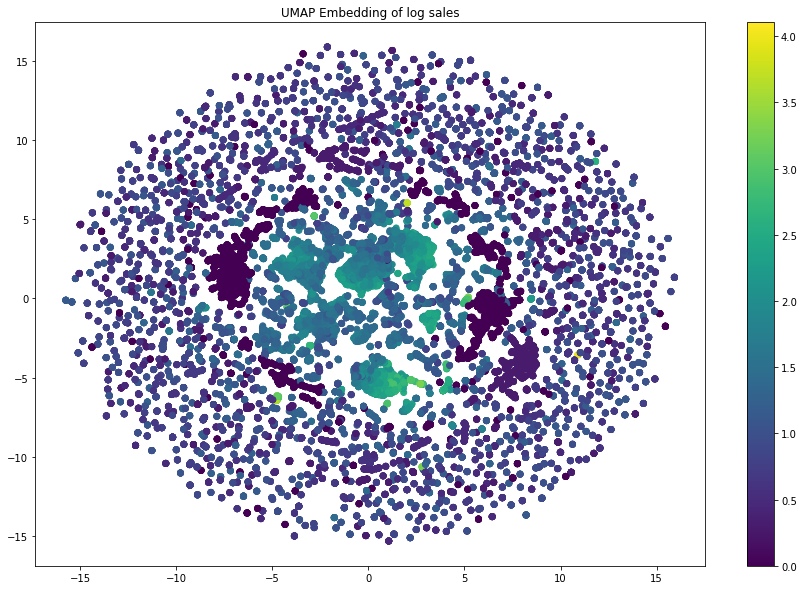

In [11]:
f, ax = plt.subplots(figsize=(15,10))
sc = ax.scatter(sales_df[0], sales_df[1], c=sales_df['sales_log'], cmap='viridis')
plt.colorbar(sc)
ax.set_title('UMAP Embedding of log sales')
plt.show()

# Clustering and cluster analysis

In [12]:
run_cont = ['sales', 'selling_price', 'avg_discount', 'stock_open']
run_cats = ['sku_department', 'sku_subdepartment', 'sku_category', 'sku_subcategory', 'sku_label']

In [13]:
som_clus = pd.read_csv('../data/output/som_clusters_shoes.csv')
som_clus.columns = ['sku_key', 'cluster']

analyze_som = AnalyzeClusters()
df_dict = analyze_som.make_dataset(product_sales, som_clus)

Cluster sizes:


In [14]:
for i, j in df_dict.items():
    print(i, len(j['sku_key'].unique()))

cluster_2 15771
cluster_0 20392
cluster_3 7776
cluster_1 903


Clusters on embedding

FileNotFoundError: [Errno 2] No such file or directory: 'images/cluster.png'

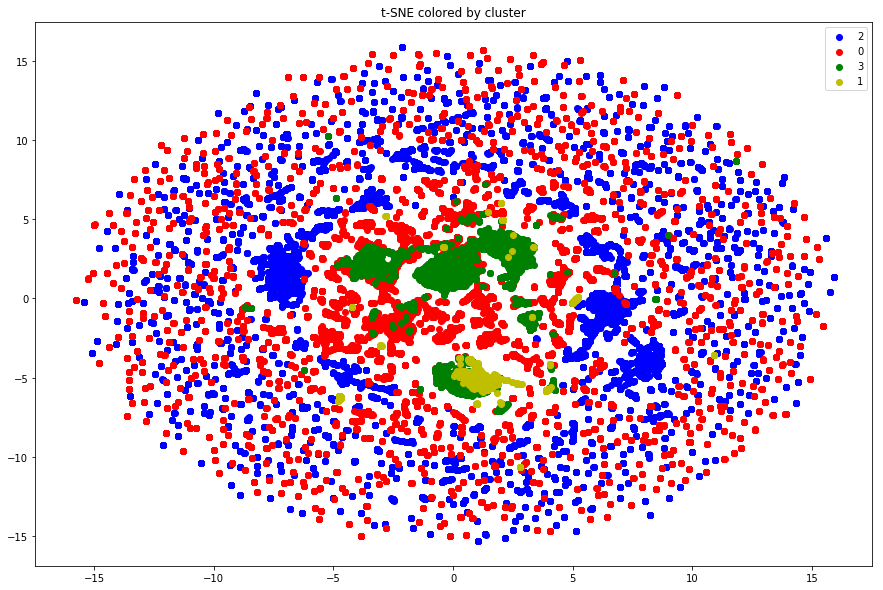

In [15]:
som_tsne = plot_df.merge(som_clus, left_on='id', right_on='sku_key')

plot_by_factor(som_tsne, 'cluster', colors, False)

Have a look at the time series for each of the clusters

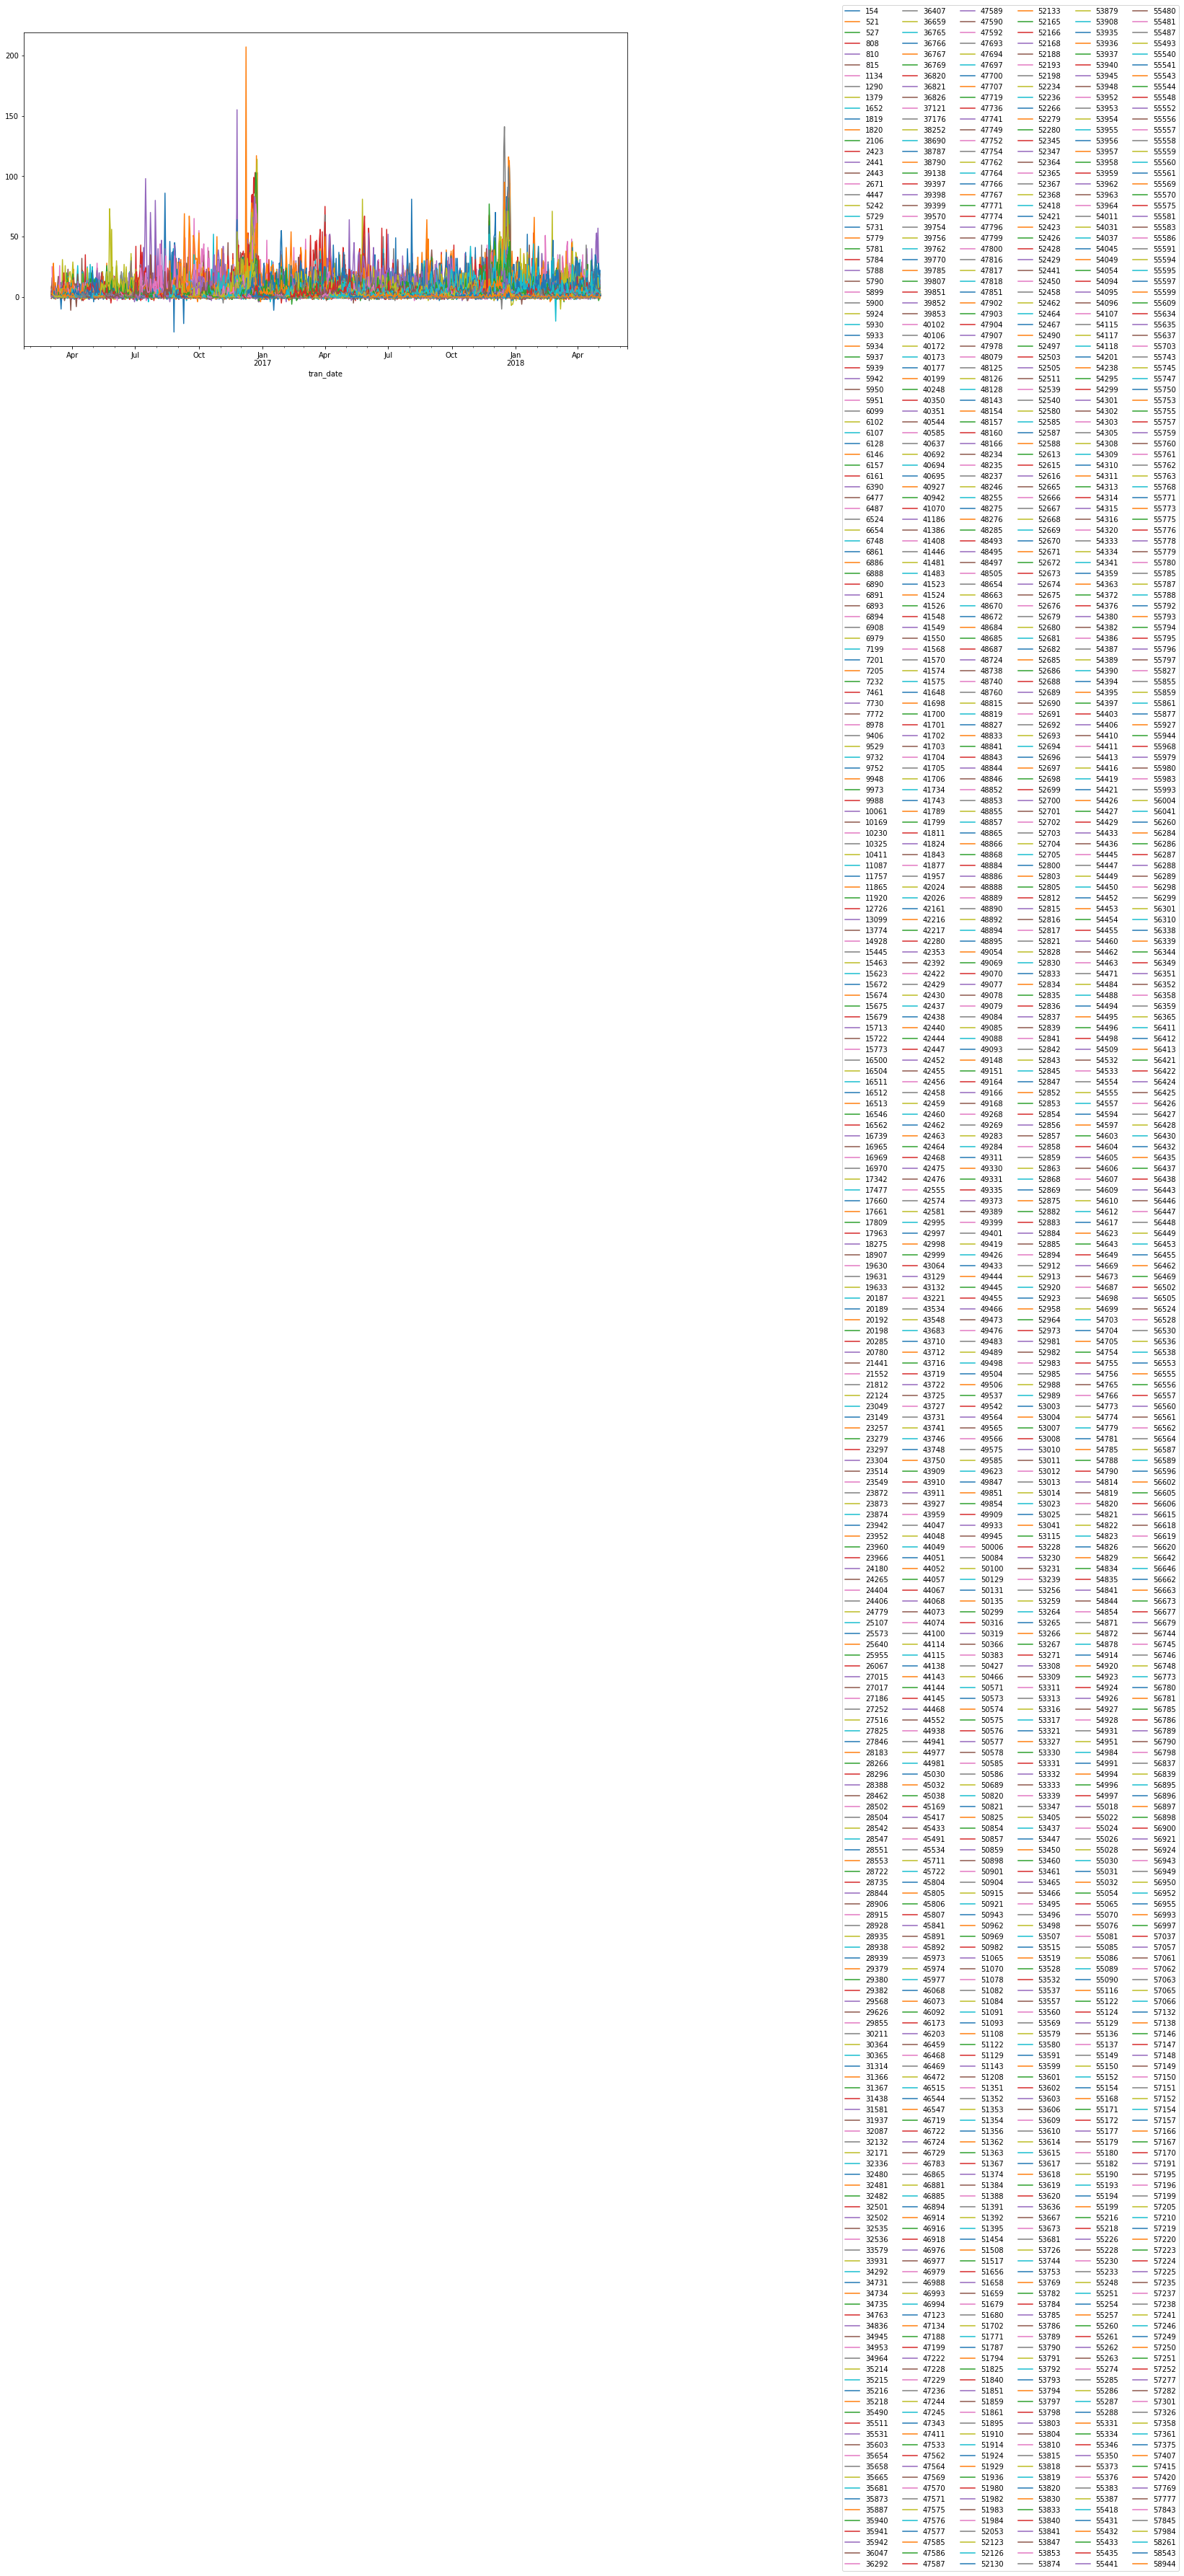

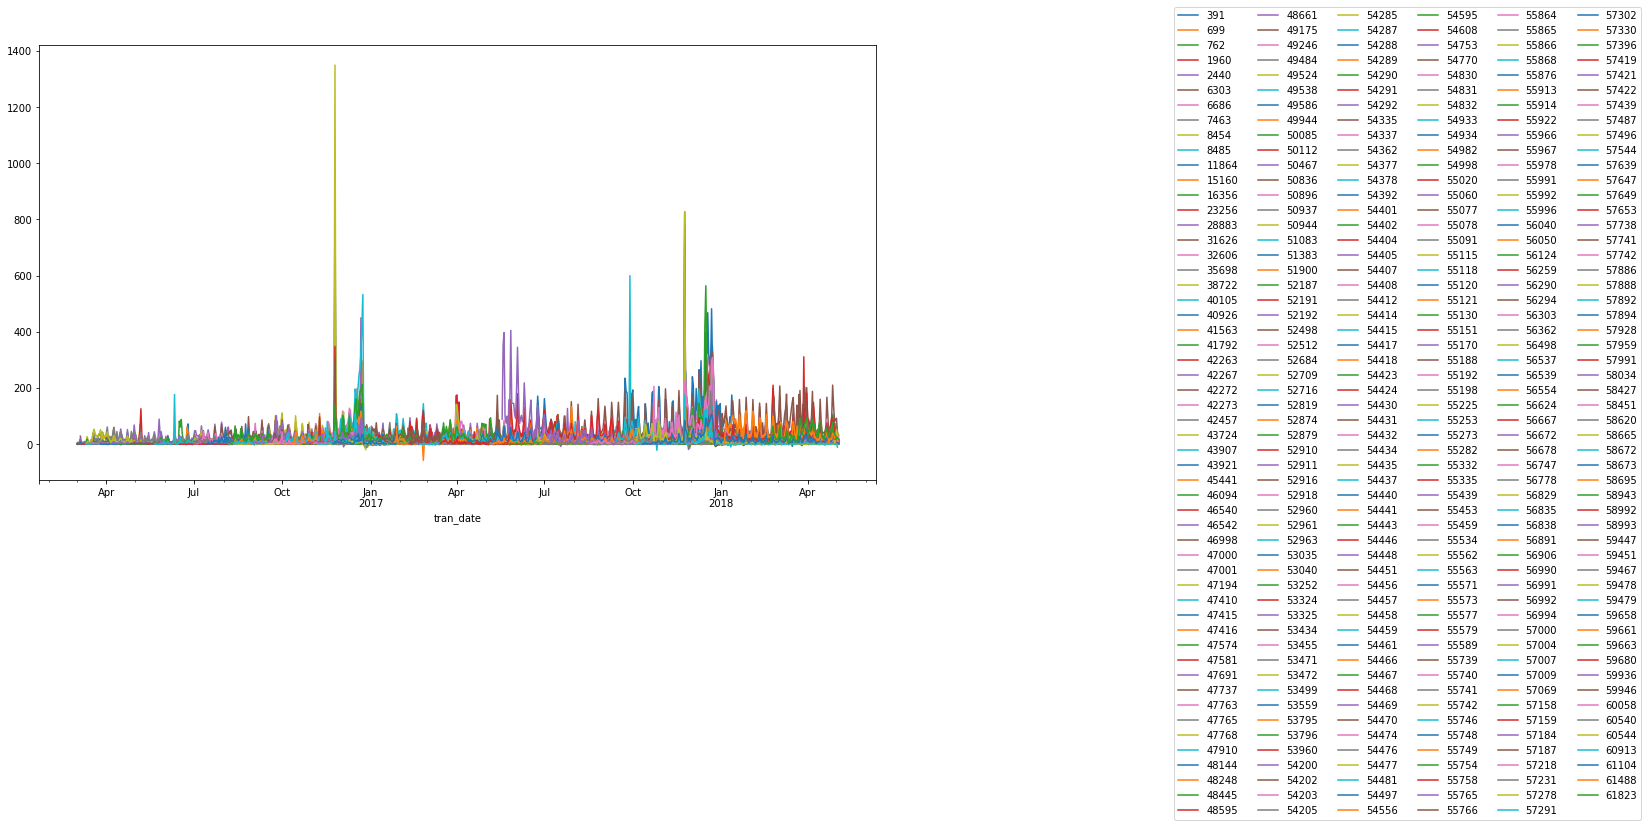

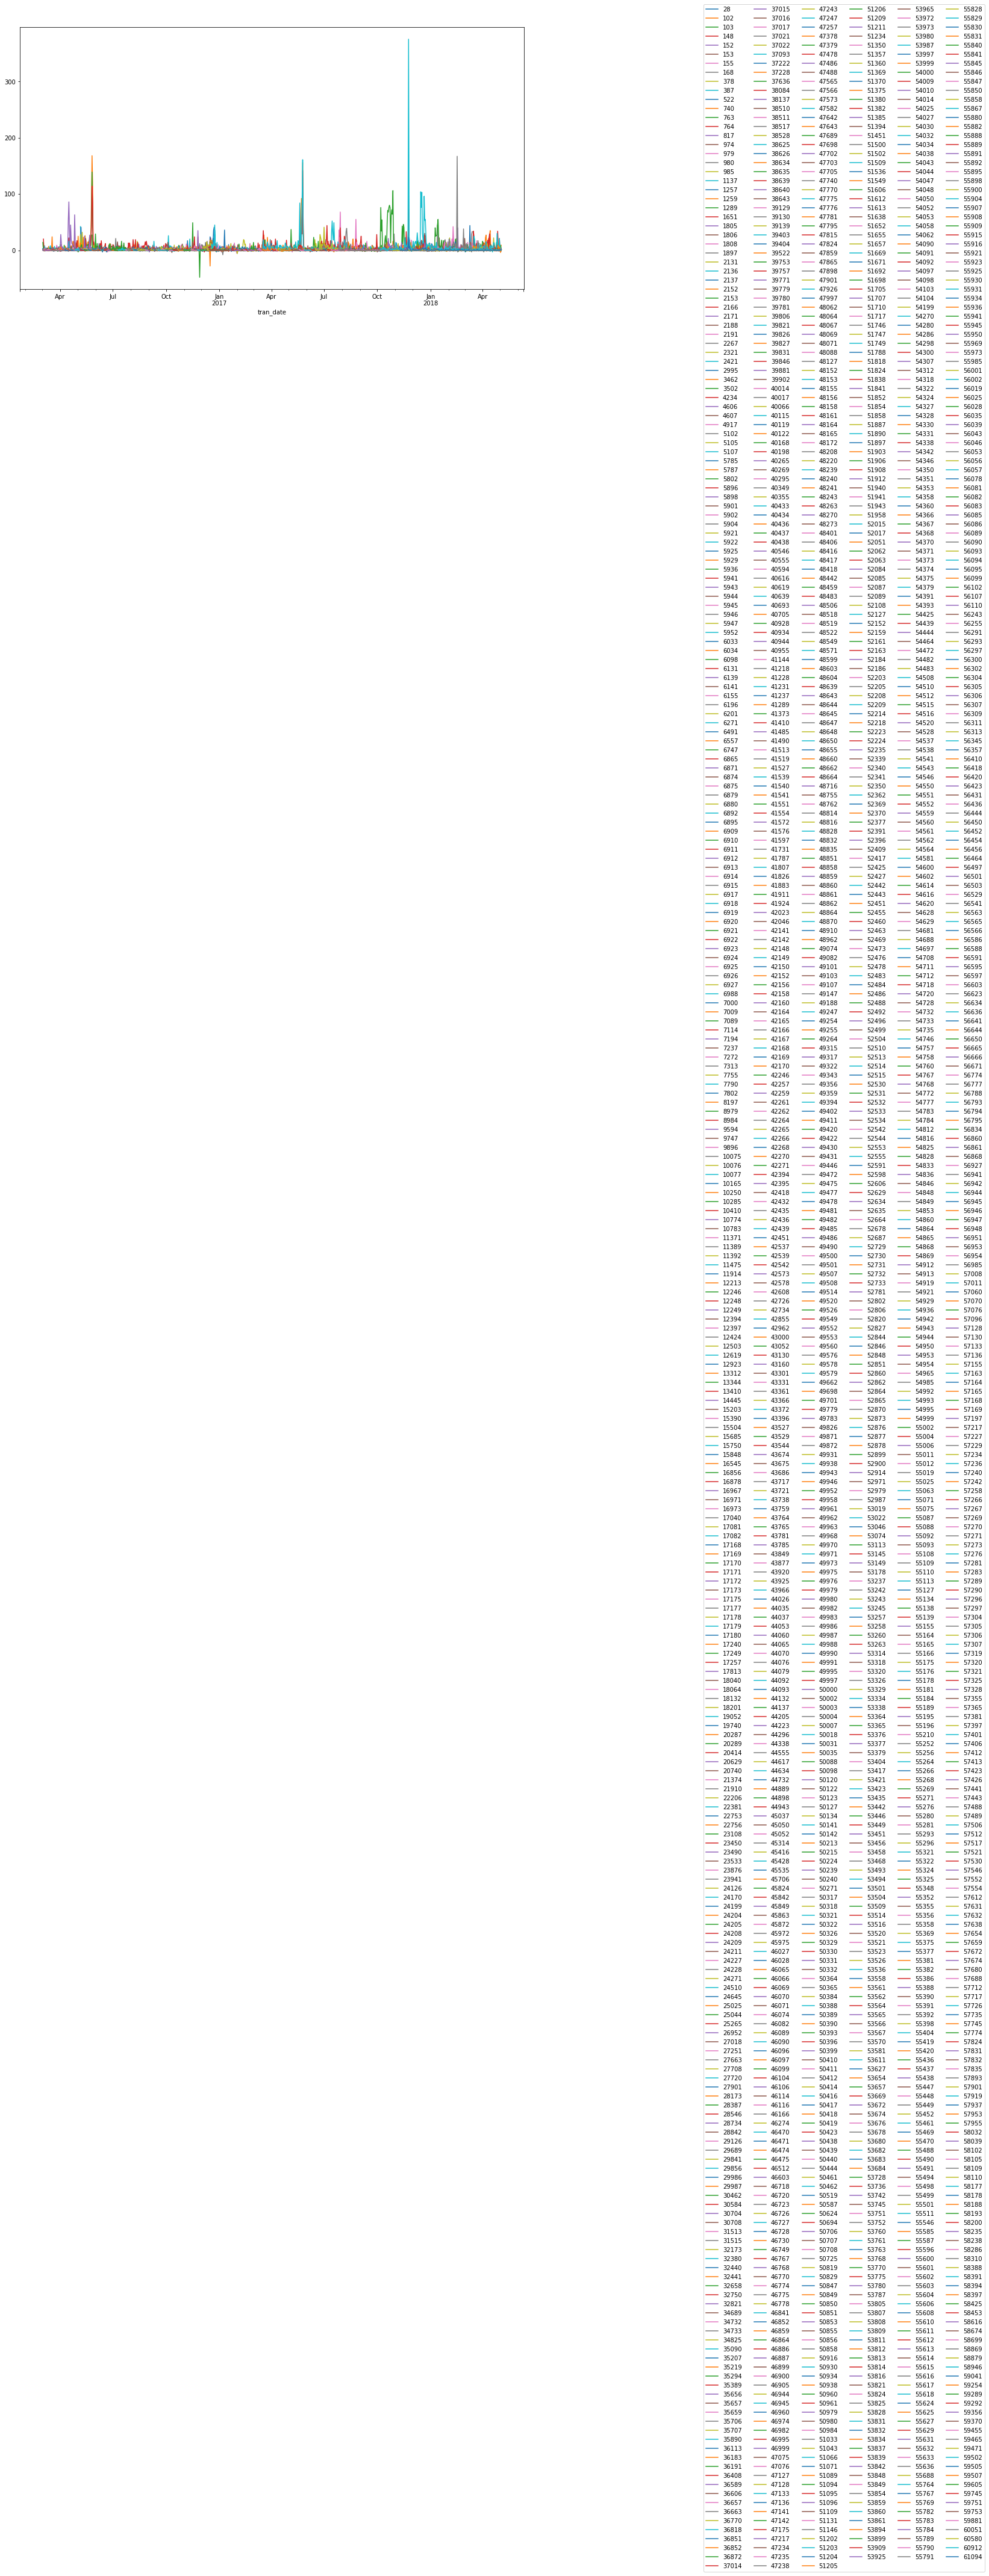

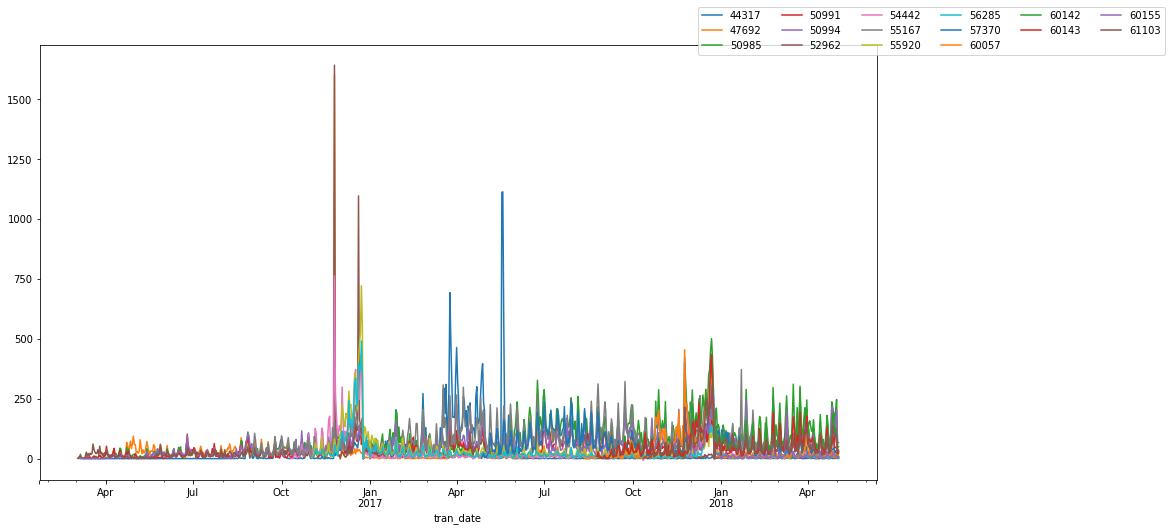

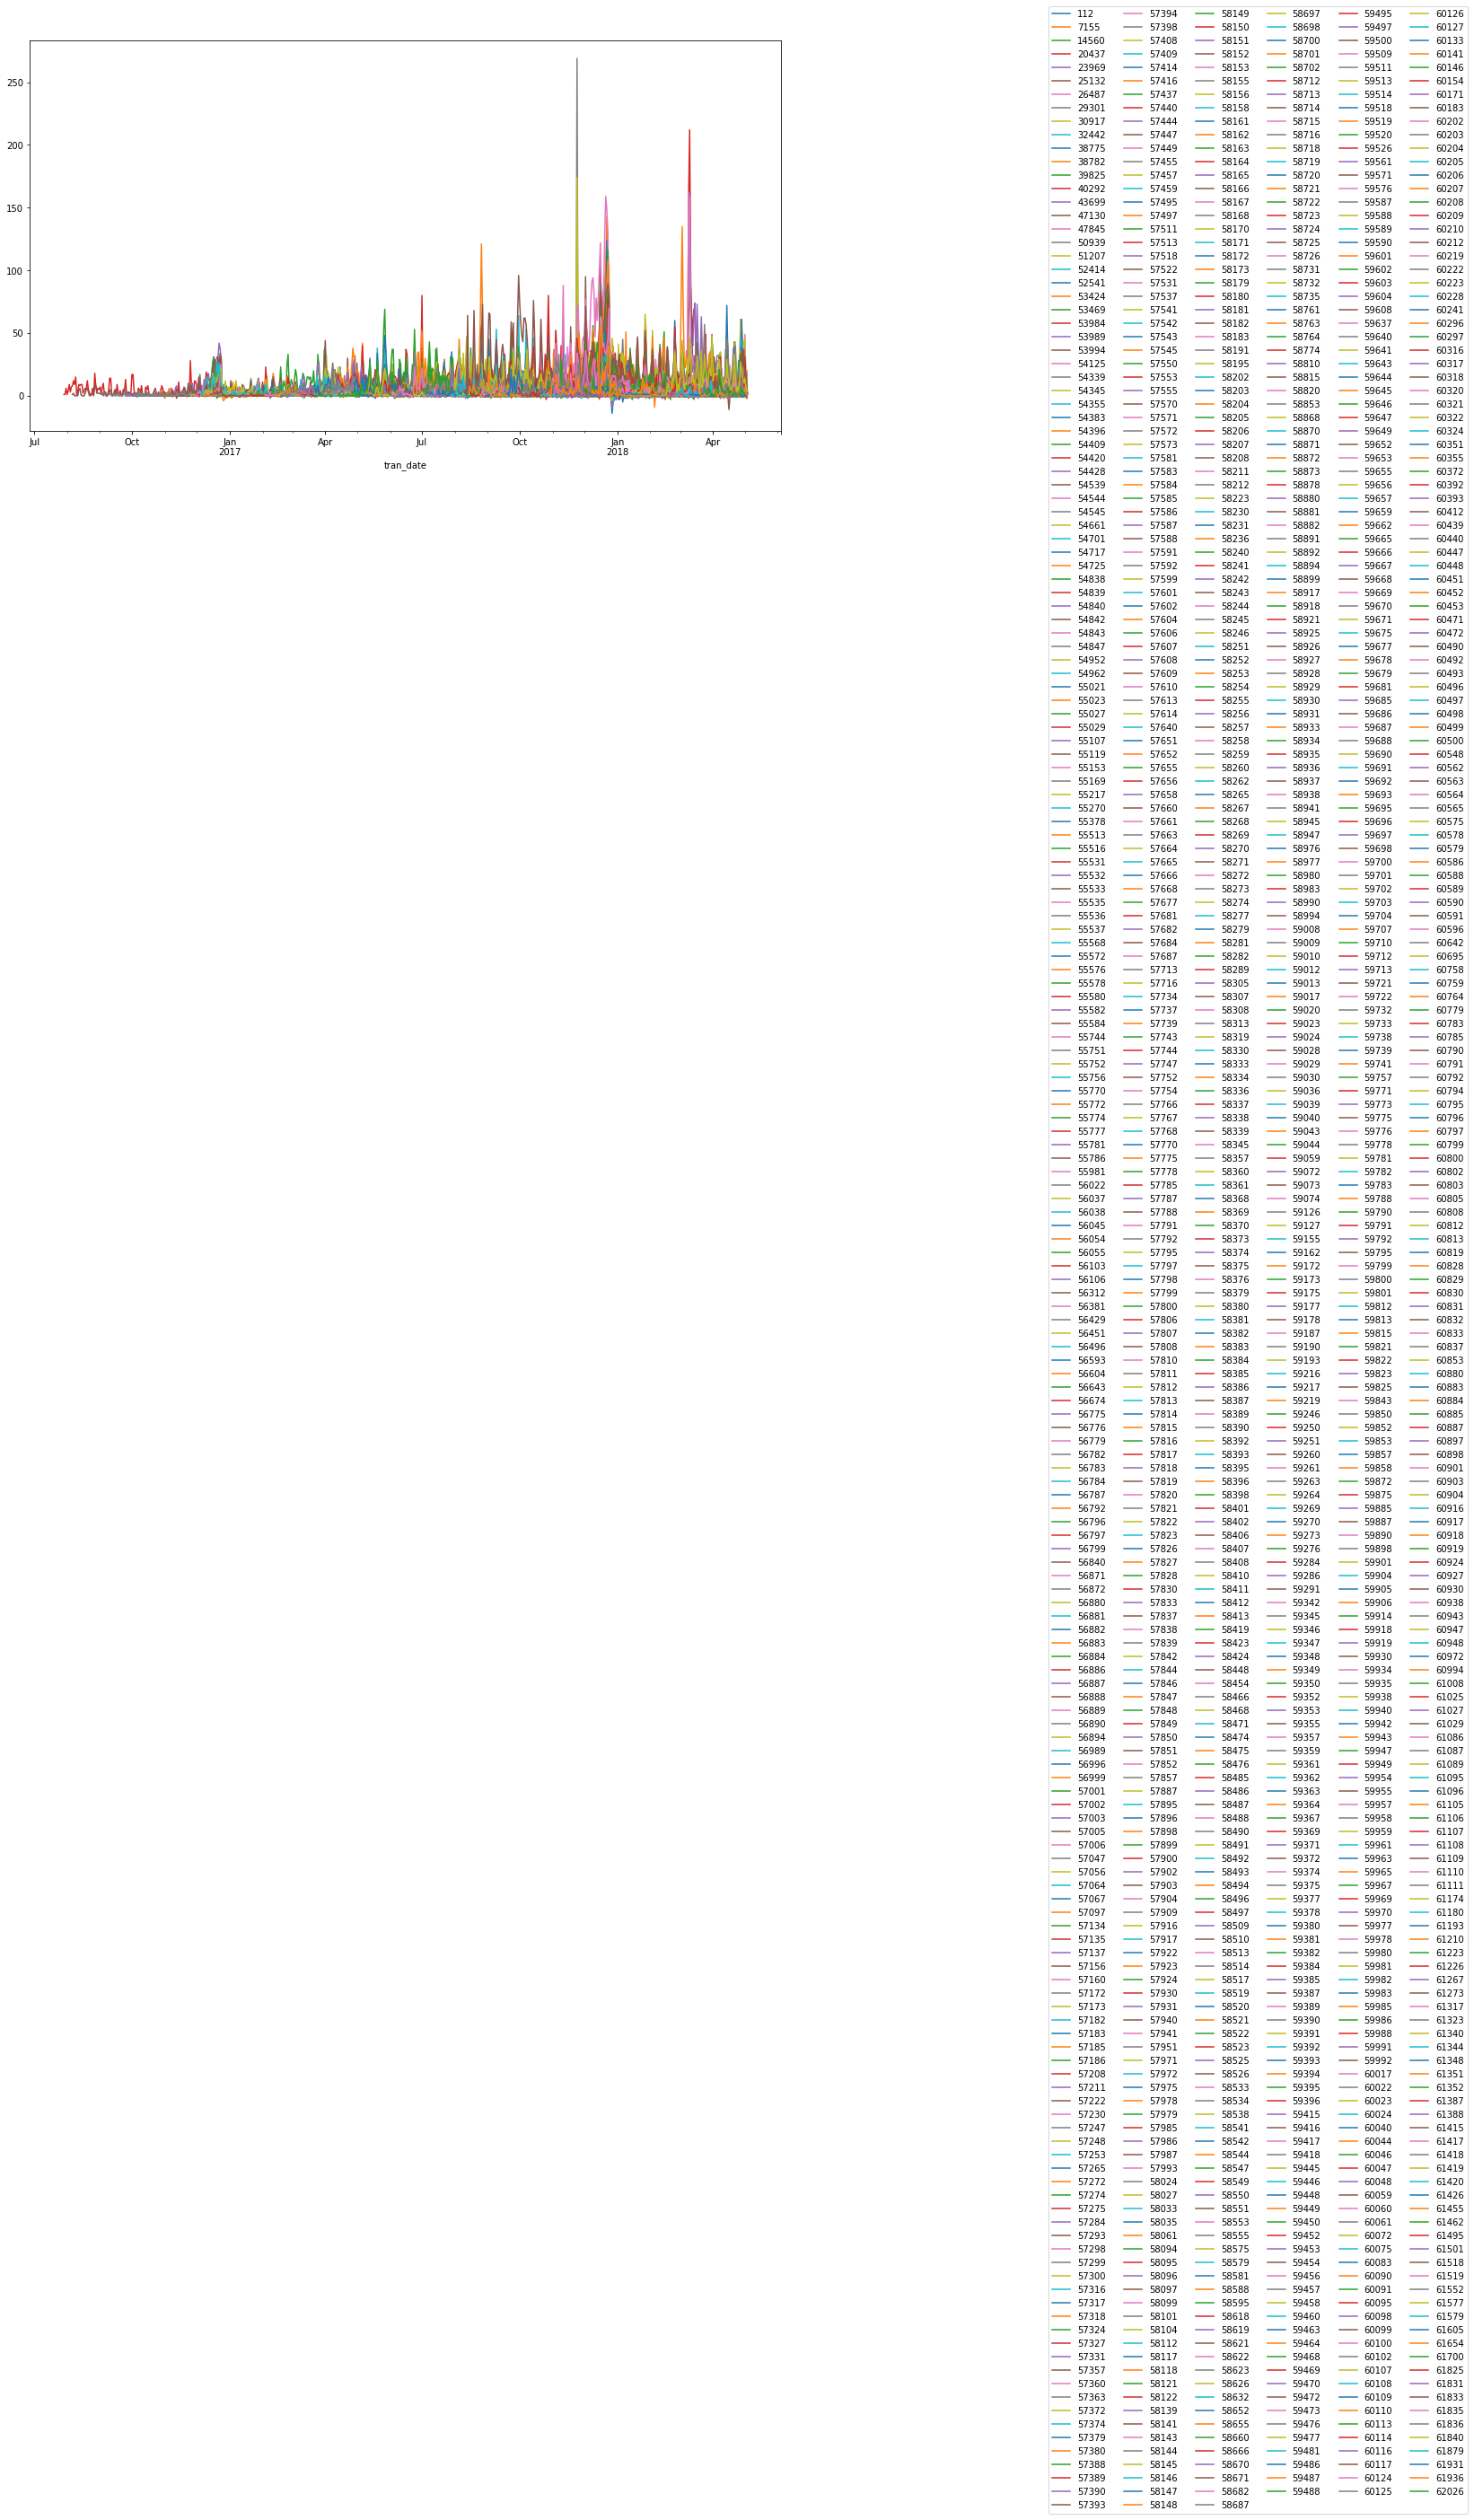

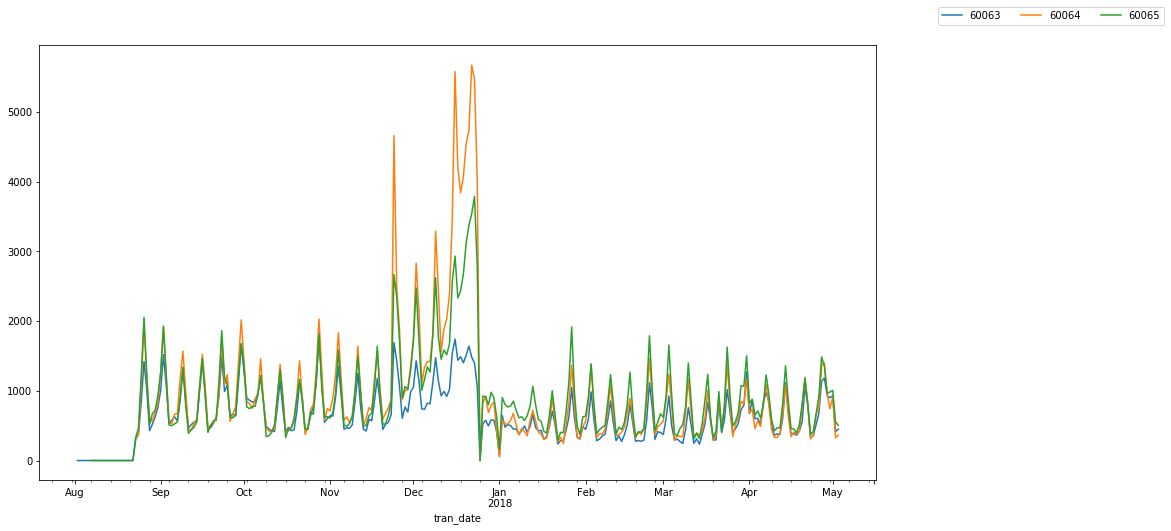

In [11]:
analyze_som.plot_all_timeseries(df_dict)

Have a look at the mean time series for each of the clusters

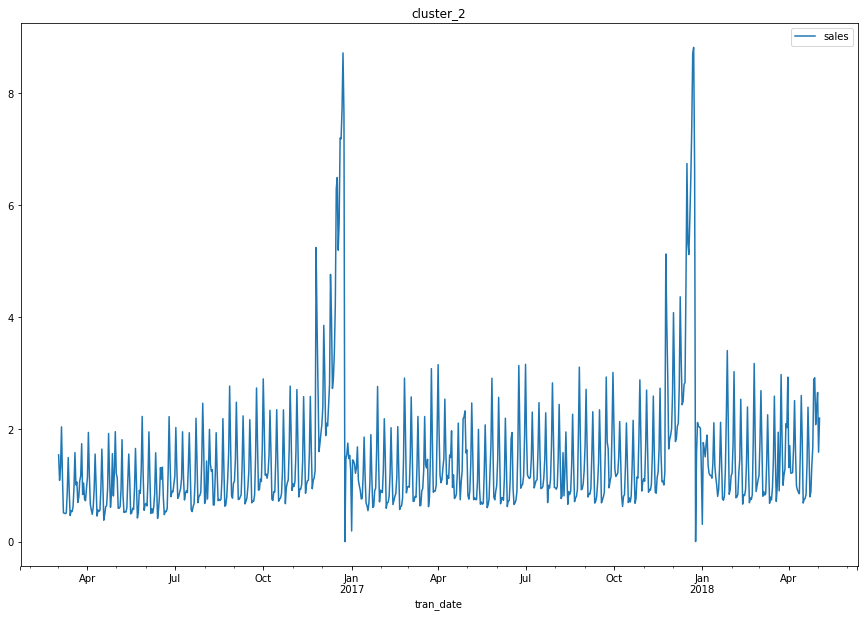

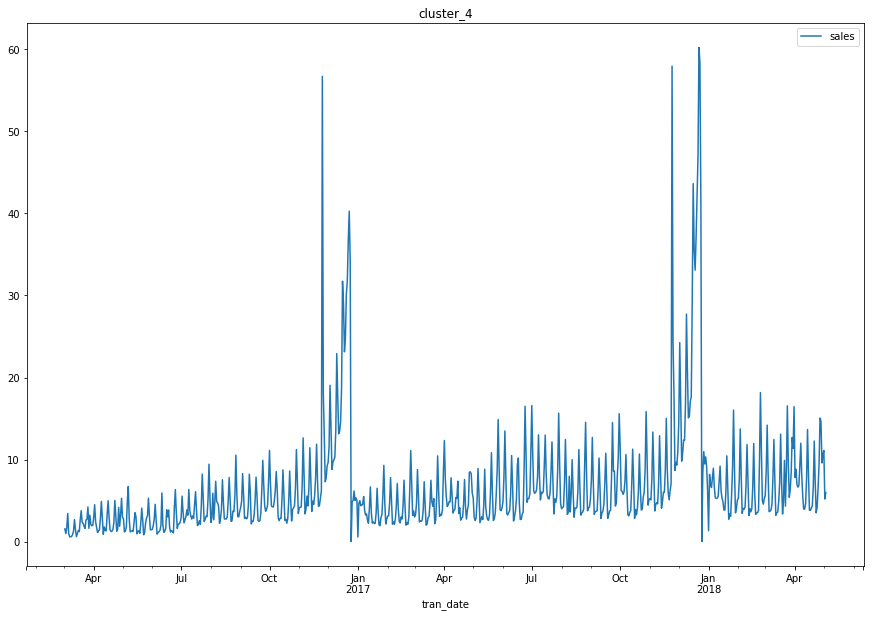

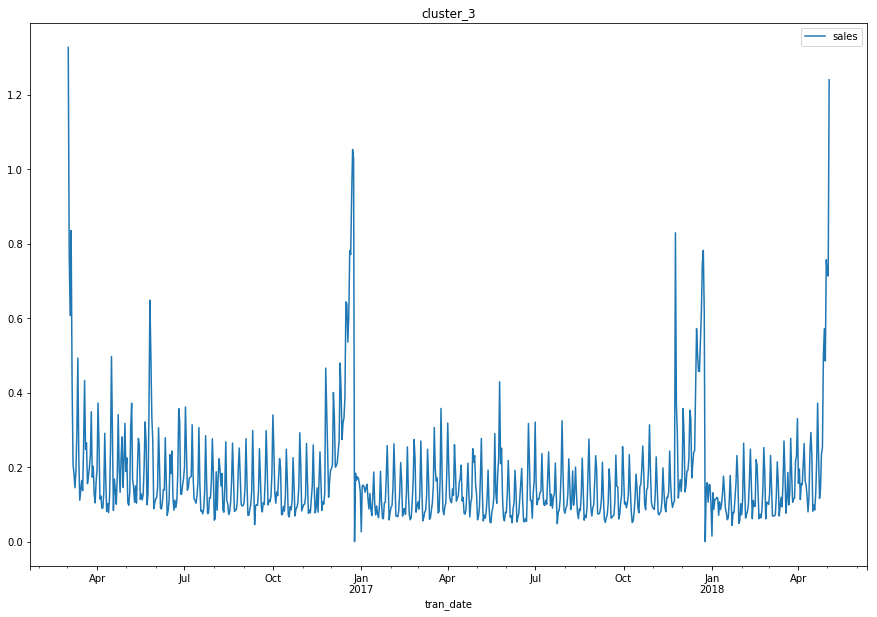

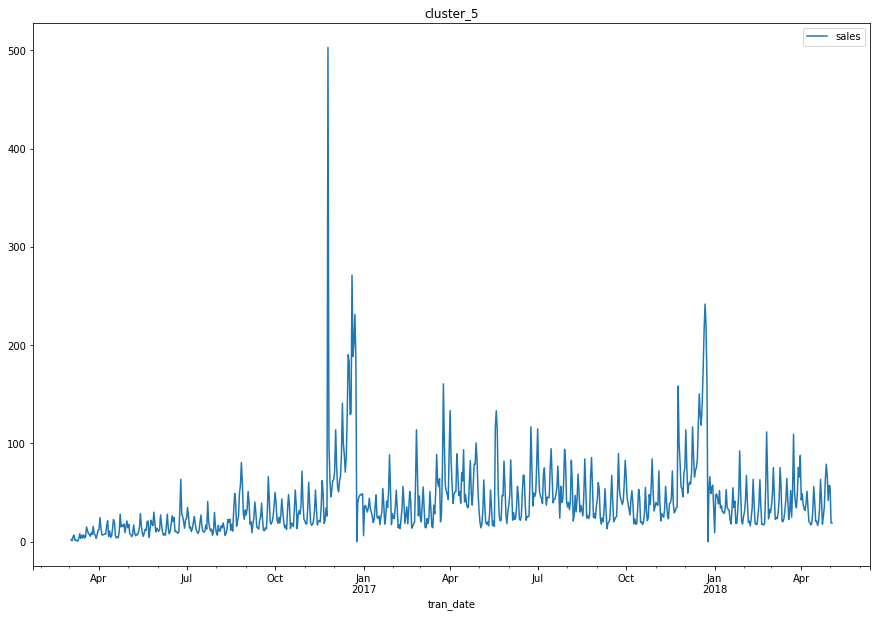

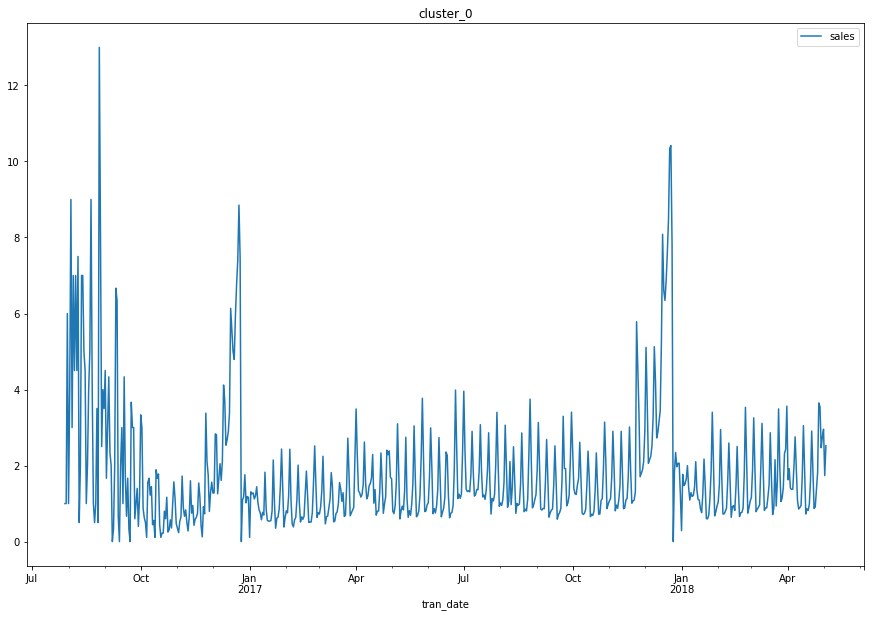

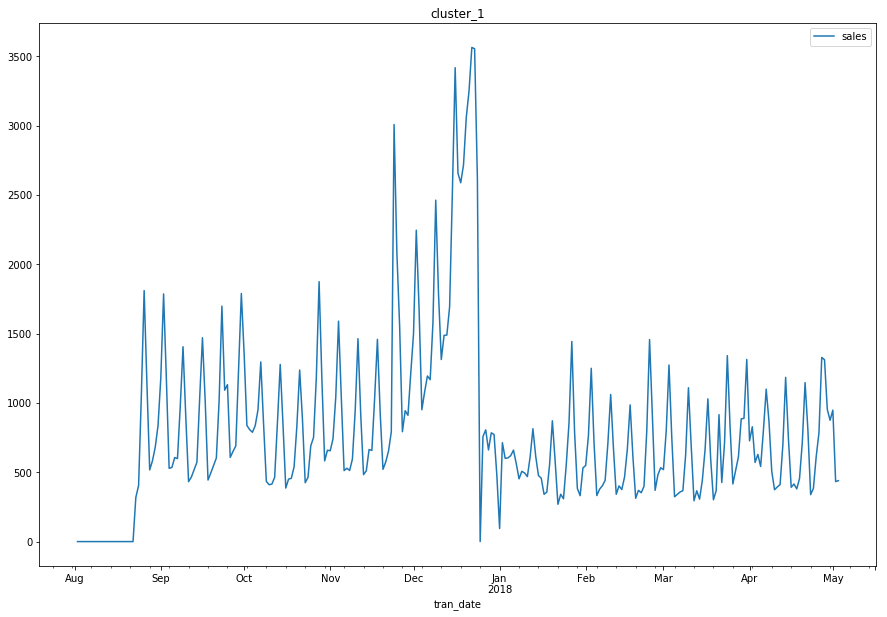

In [12]:
analyze_som.plot_mean_timeseries(df_dict)

Have a look at the median time series for each of the clusters

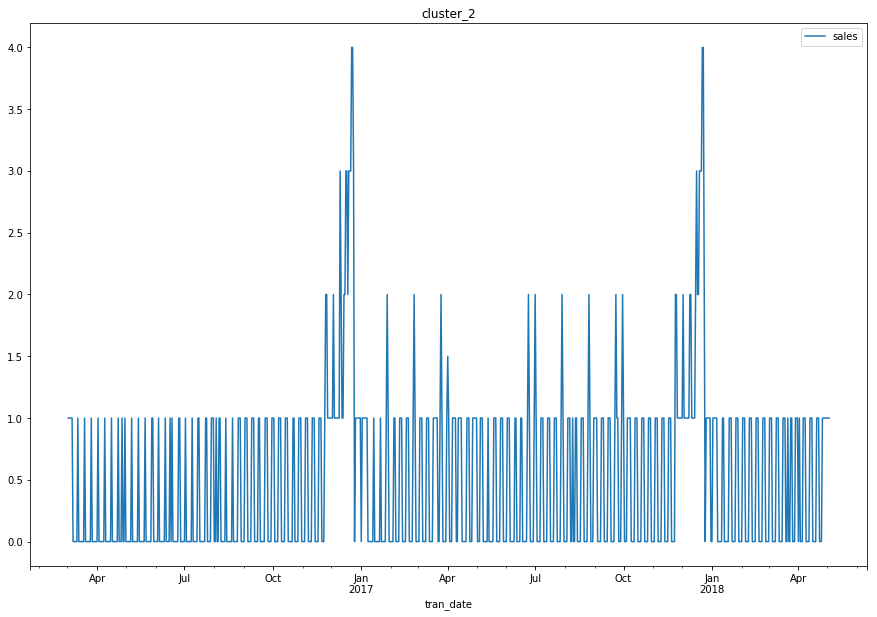

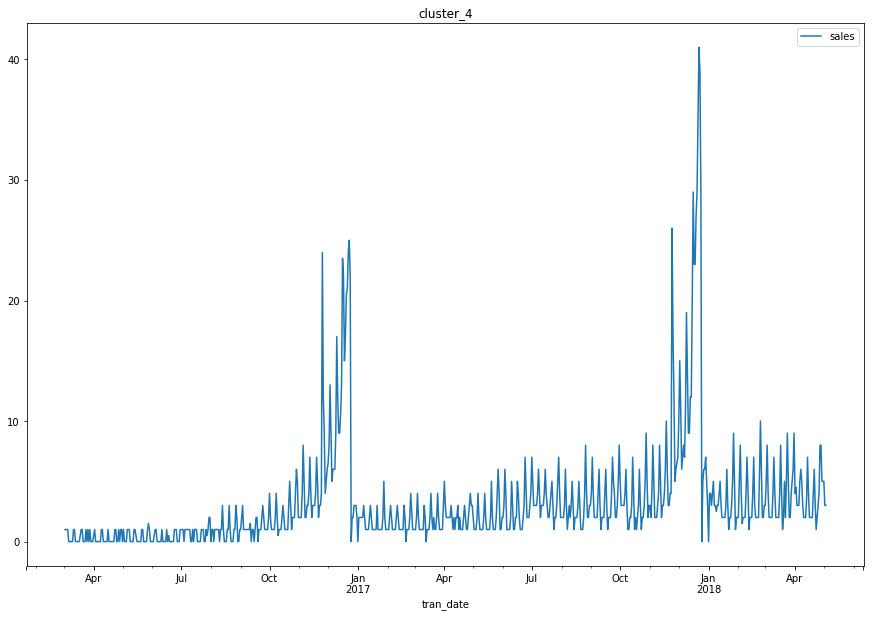

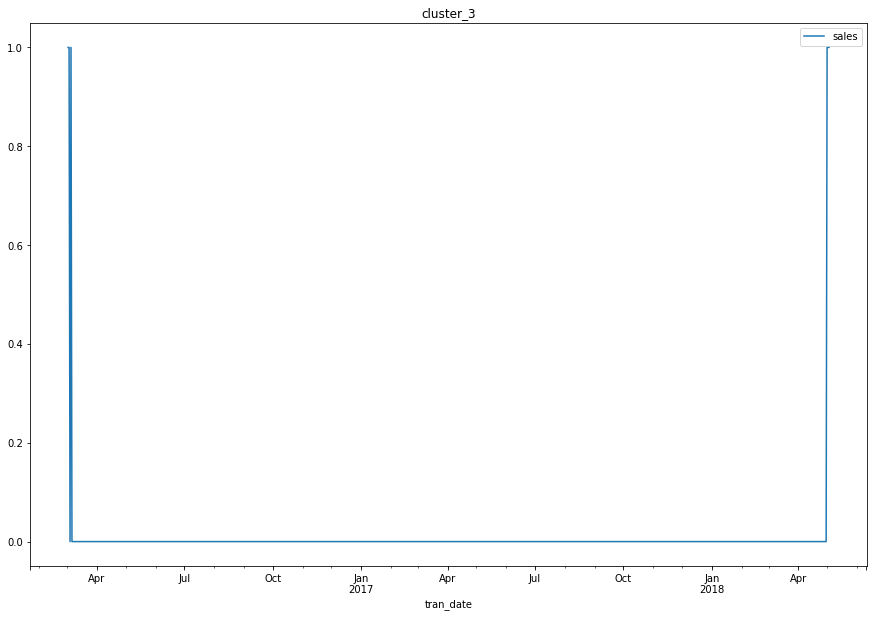

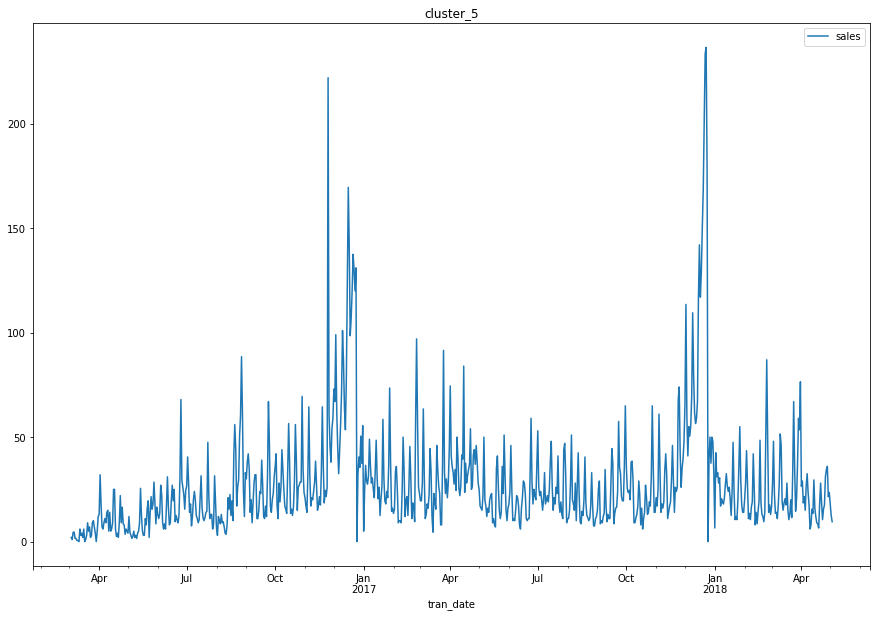

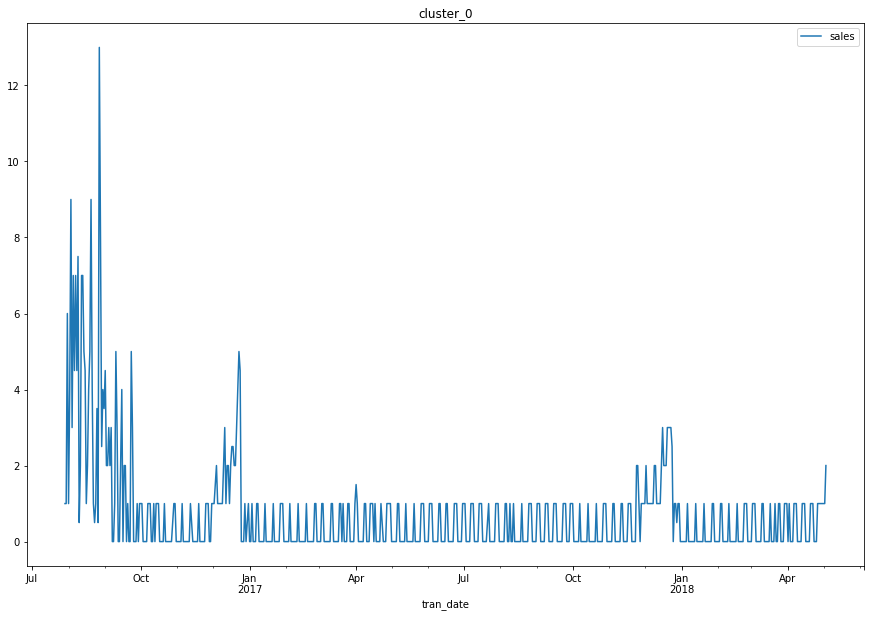

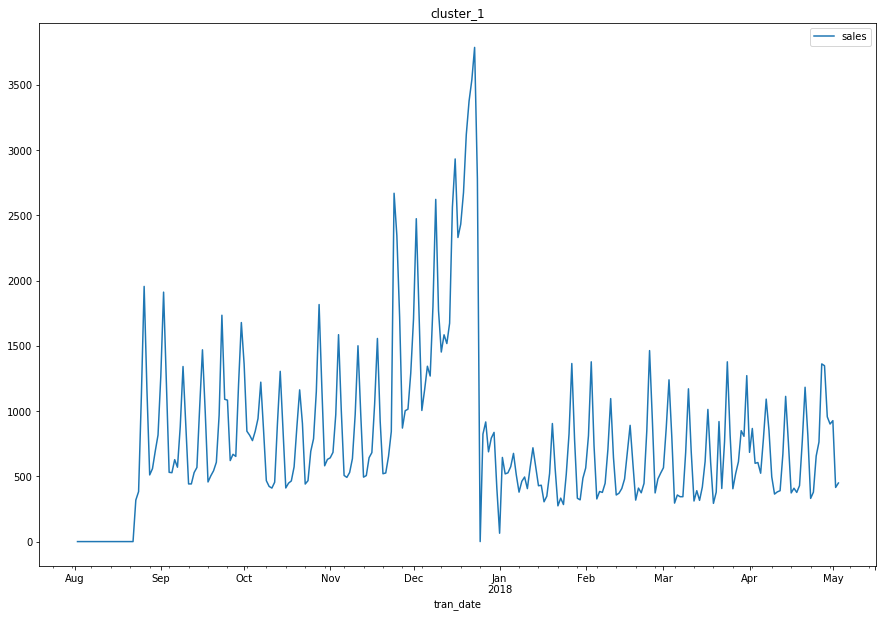

In [13]:
analyze_som.plot_median_timeseries(df_dict)

Have a look at the smoothed mean for each of the clusters

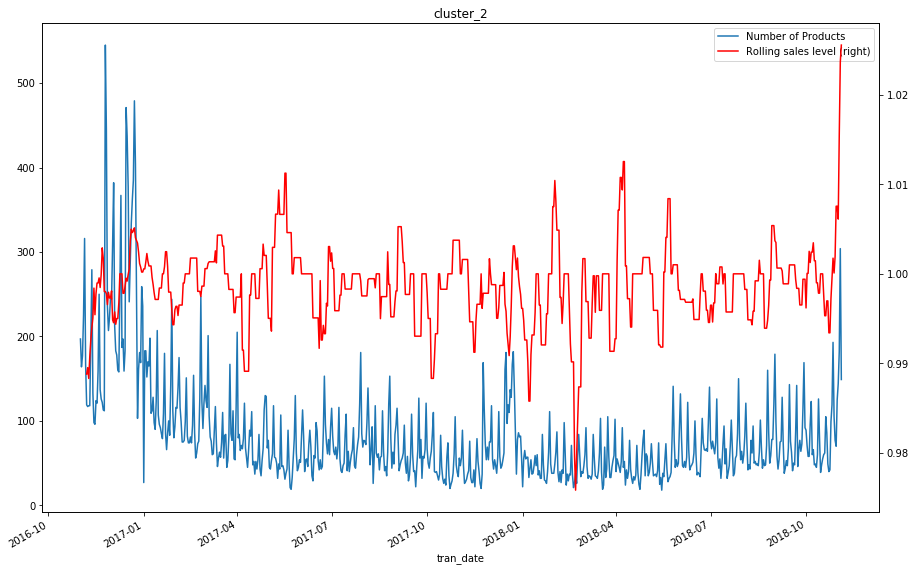

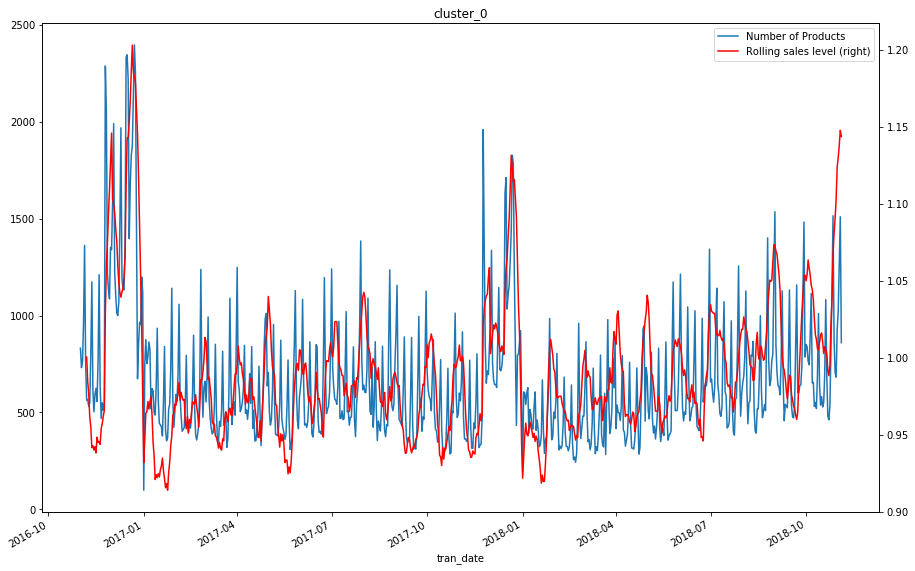

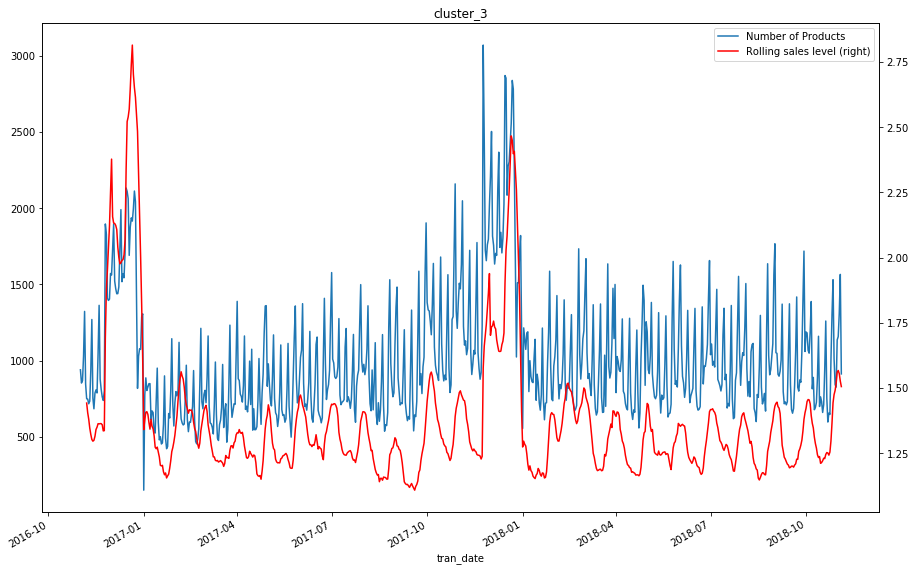

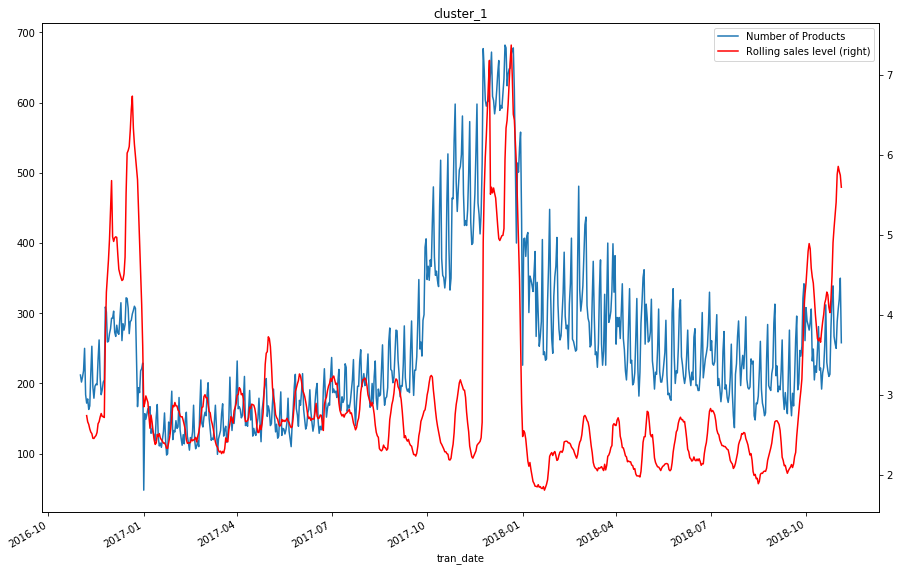

In [16]:
analyze_som.plot_rolling_mean_timeseries(df_dict, 'sales', plot_second=True,  period=7)

KeyError: "['stock_open'] not in index"

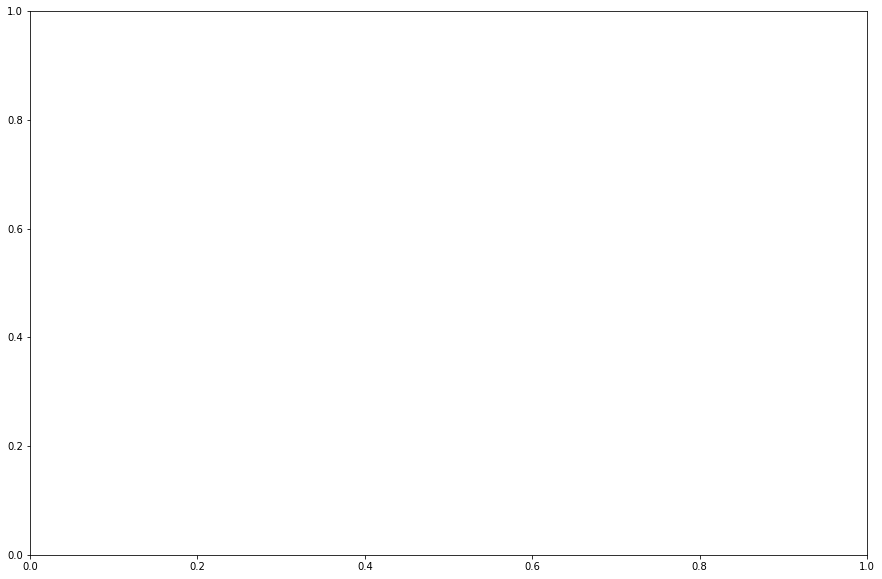

In [17]:
analyze_som.plot_rolling_mean_timeseries(df_dict, 'stock_open', plot_second=True,  period=7)

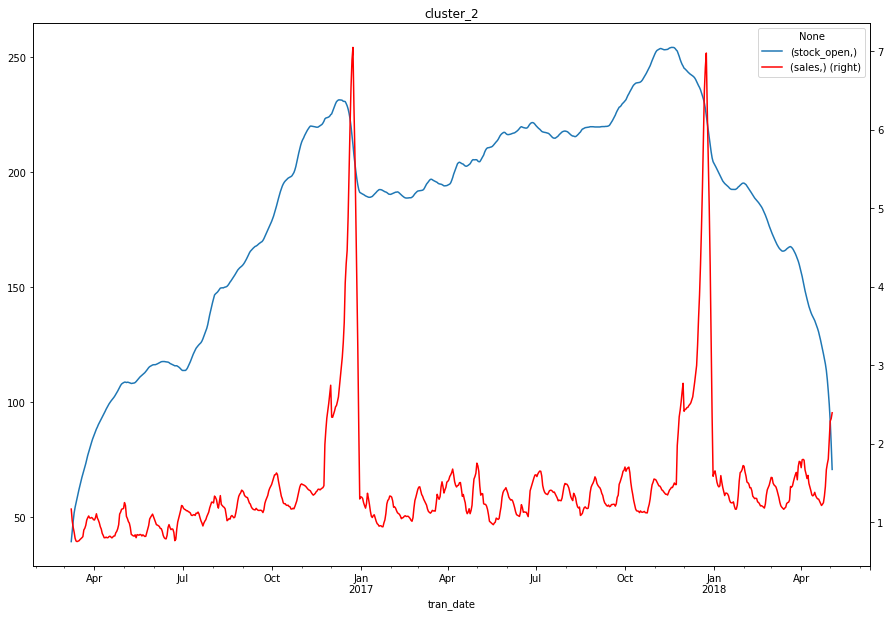

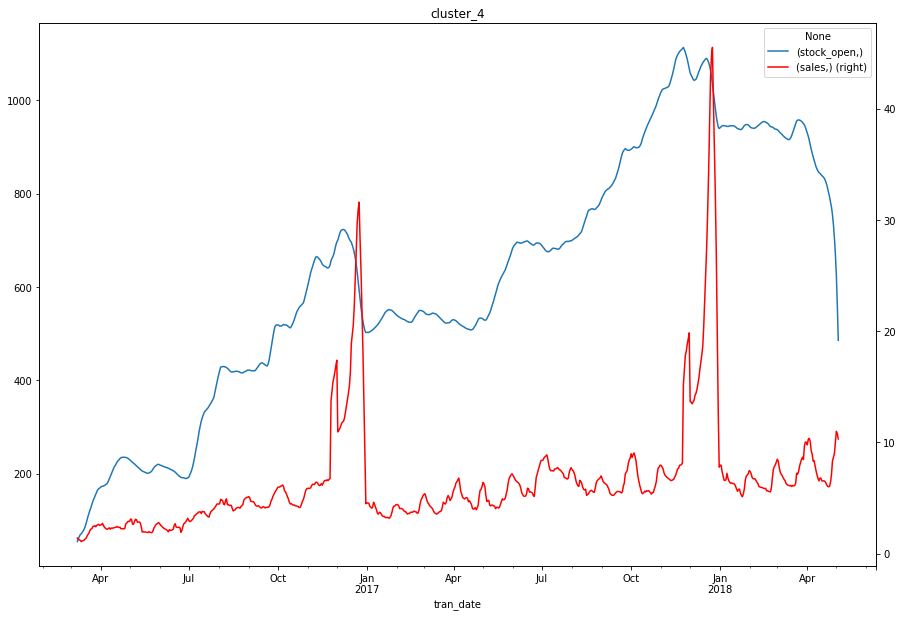

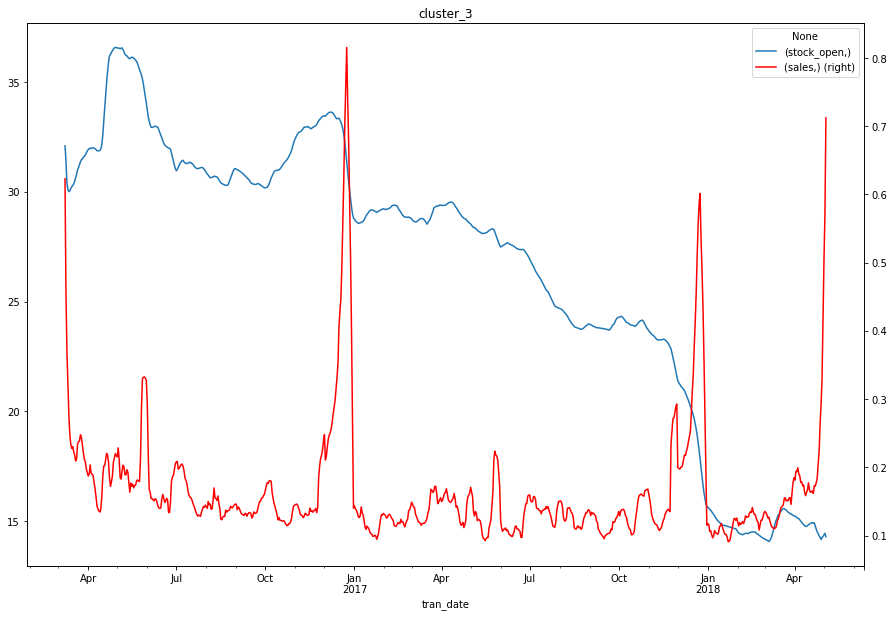

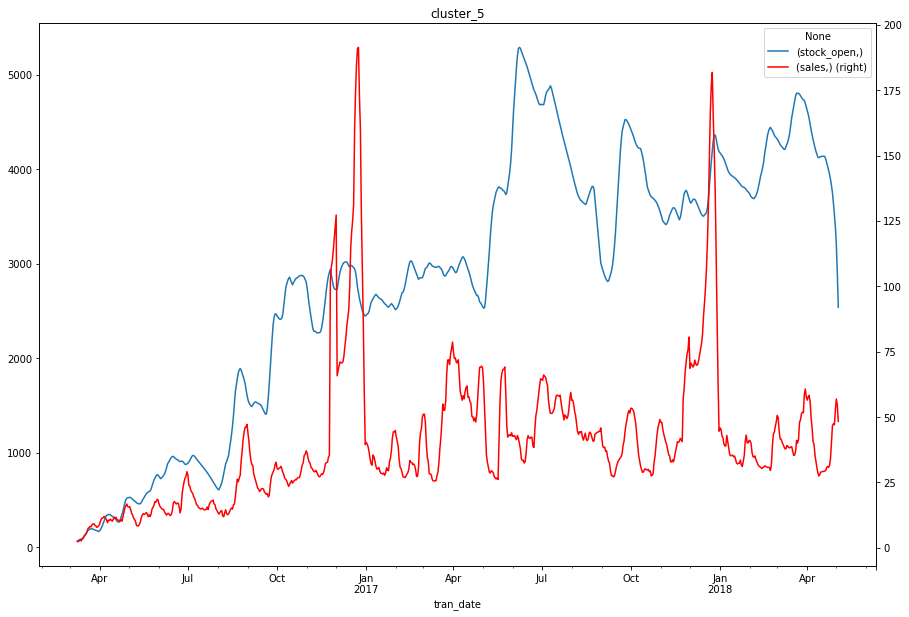

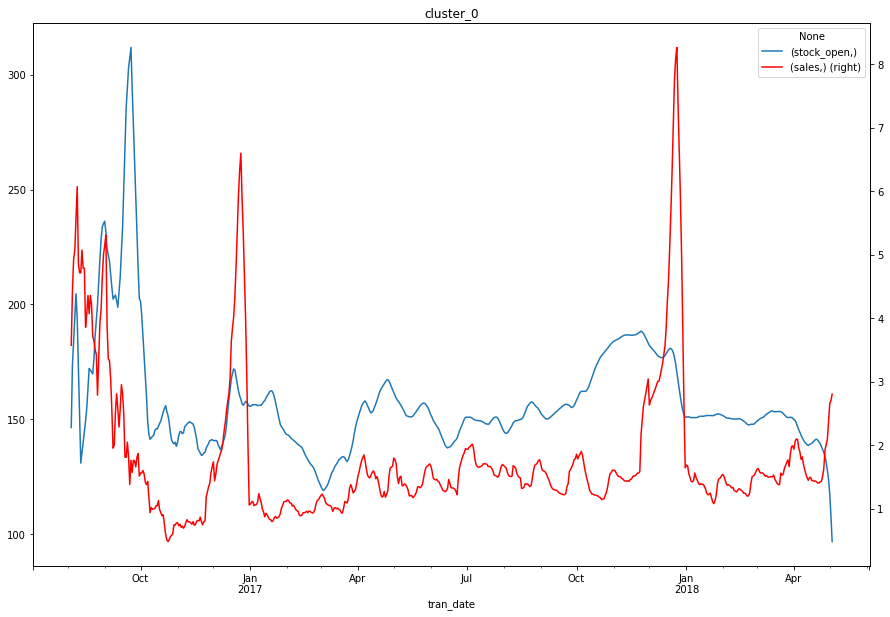

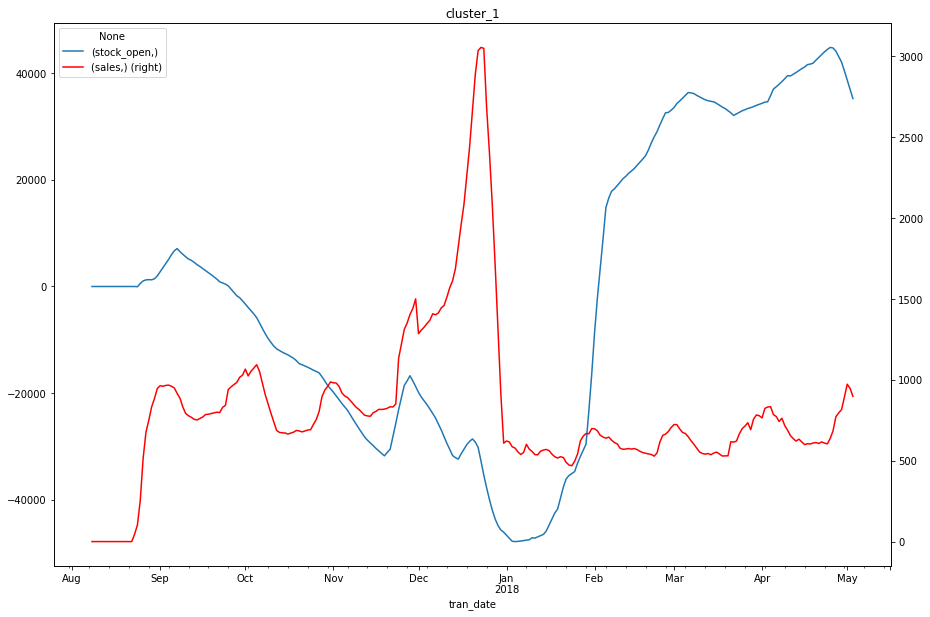

In [15]:
analyze_som.plot_double_rolling_mean(df_dict, ['stock_open', 'sales'], plot_second=True,  period=7)

Have a look at the amount of time series which start within the specified period or which started priod to the start of the period

cluster_2, there are 1422 skus and 1506407 sales.


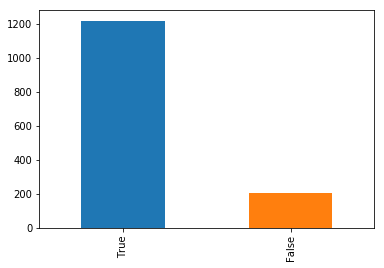

cluster_4, there are 323 skus and 1376825 sales.


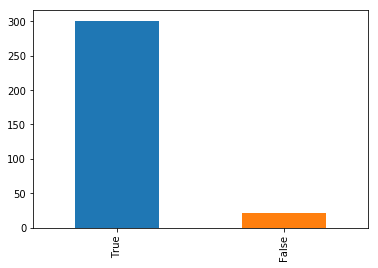

cluster_3, there are 1701 skus and 176410 sales.


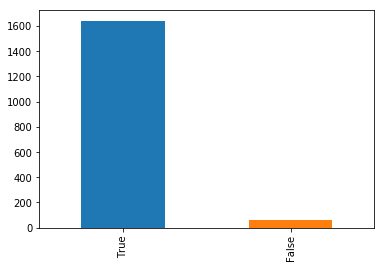

cluster_5, there are 16 skus and 373702 sales.


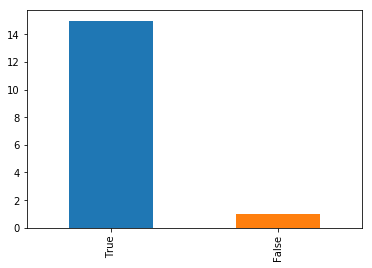

cluster_0, there are 1113 skus and 582625 sales.


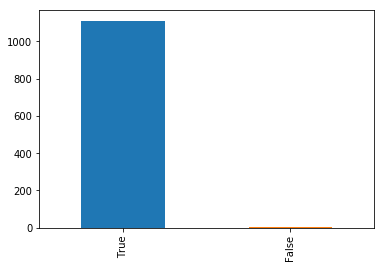

cluster_1, there are 3 skus and 667649 sales.


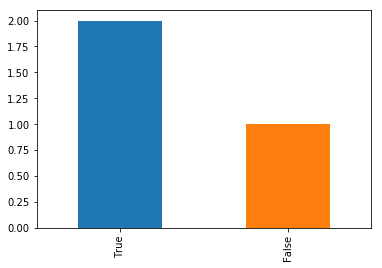

In [17]:
for i, j in df_dict.items():
    print('{}, there are {} skus and {} sales.'.format(i, len(j['sku_key'].unique()), sum(j['sales'])))
    pivot_t = pd.pivot_table(j, index='sku_key', columns='tran_date', values='sales')
    pivot_t['nan'] = pivot_t.iloc[:,0].apply(np.isnan)
    pivot_t['nan'].value_counts().plot(kind='bar')
    plt.show()

Have a look at the distribution of the continuous variables for each cluster

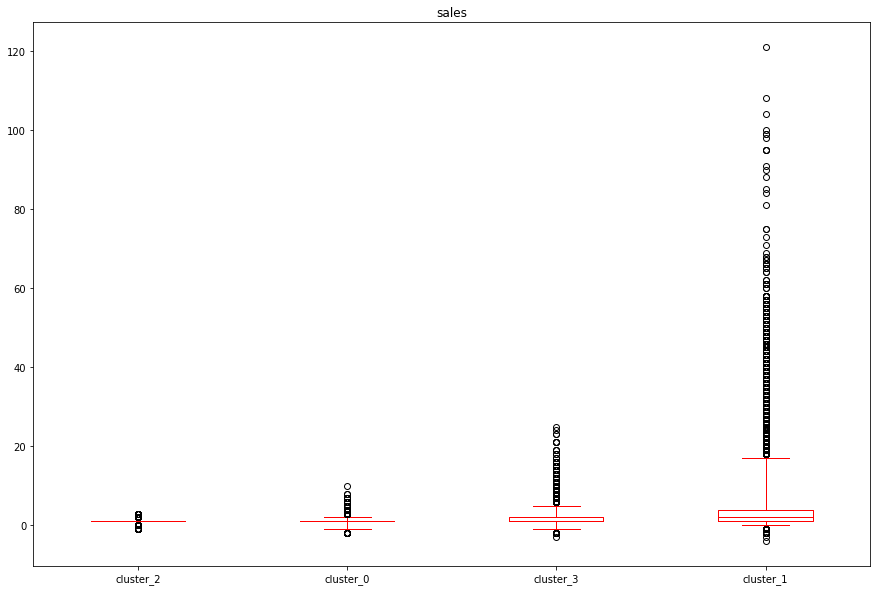

KeyError: 'selling_price'

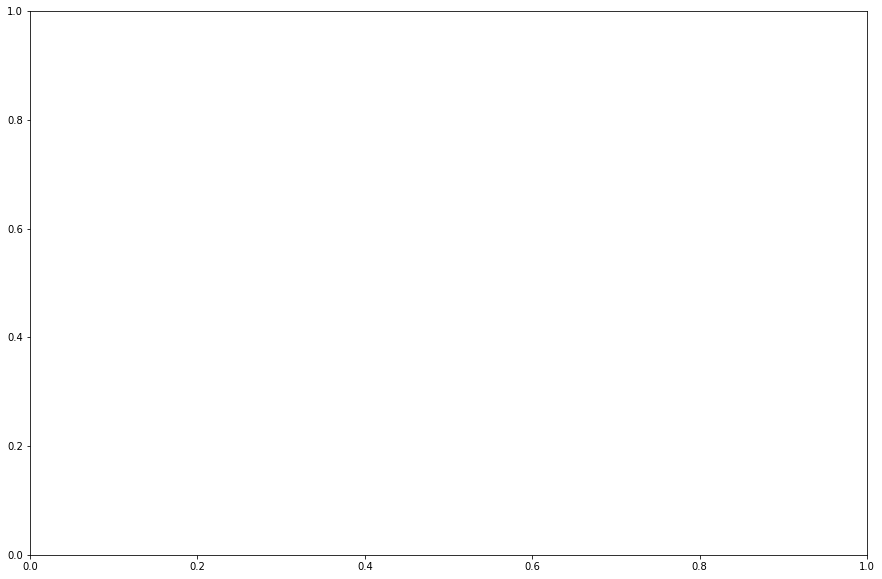

In [18]:
analyze_som.plot_cluster_continuous_box(df_dict, run_cont, True)
#OPTIONAL BELOW
#analyze_som.plot_cluster_continuous(df_dict, run_cont, colors, True)
#analyze_som.plot_cluster_continuous_violin(df_dict, run_cont, True)

Have a look at the number of returns per cluster and relative percentage

cluster_2 had 60422 sale events
cluster_0 had 484027 sale events
cluster_3 had 742835 sale events
cluster_1 had 187610 sale events


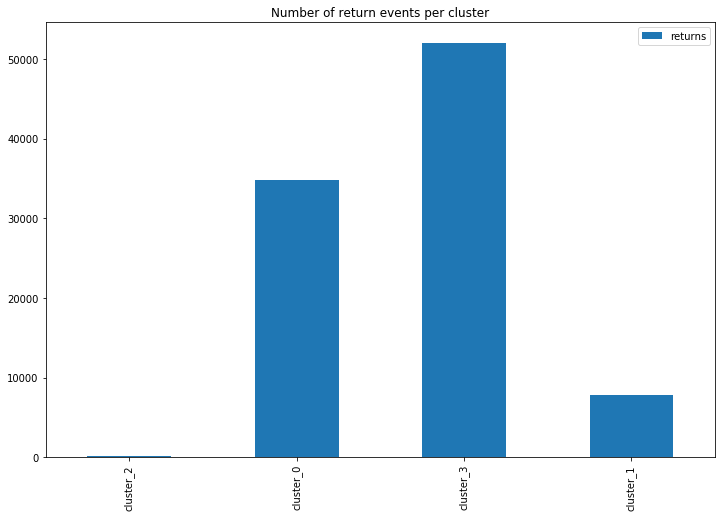

In [20]:
listy = {}
for a, i in df_dict.items():
    print('{} had {} sale events'.format(a, len(i['sales'])))
    x = i[i['sales'] <= 0]['sales'].count()
    listy[a] = x
f, ax = plt.subplots(figsize=(12,8))
pd.DataFrame(listy, index=['returns']).T.plot(kind='bar', ax=ax)
plt.title('Number of return events per cluster')
plt.show()

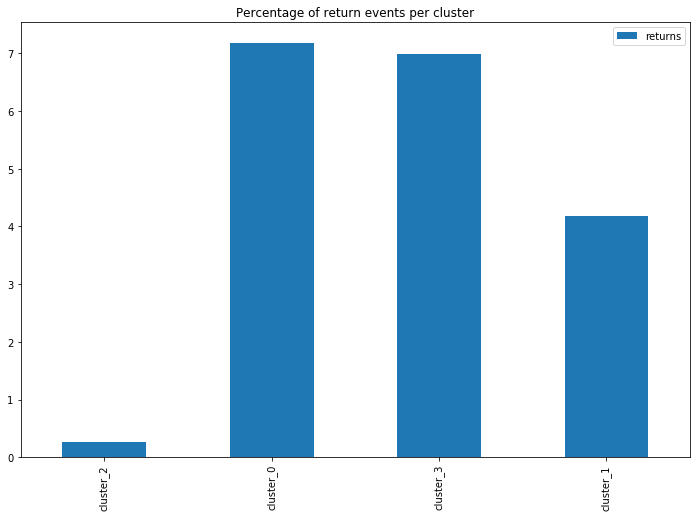

In [22]:
listy = {}
for a, i in df_dict.items():
    x = i[i['sales'] <= 0]['sales'].count()/i['sales'].count()*100
    listy[a] = x
    
f, ax = plt.subplots(figsize=(12,8))
pd.DataFrame(listy, index=['returns']).T.plot(kind='bar', ax=ax)
plt.title('Percentage of return events per cluster')
plt.show()

Look at the stock shortages

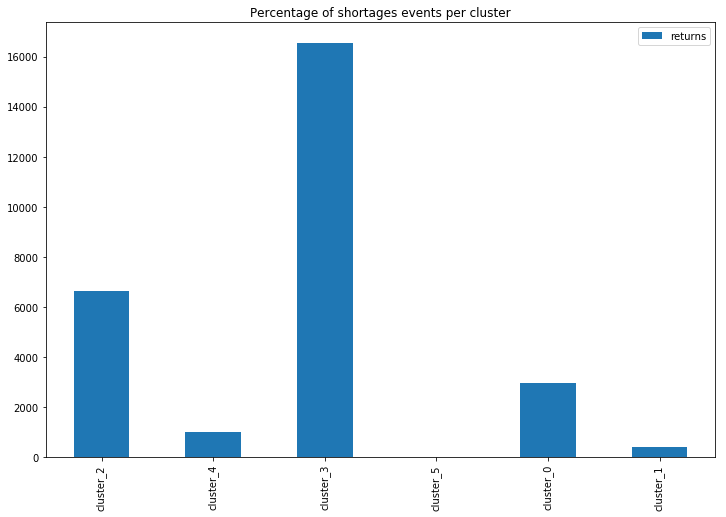

In [21]:
listy = {}
for a, i in df_dict.items():
    x = i[i['stock_open'] < 0]['stock_open'].count()
    listy[a] = x
    
f, ax = plt.subplots(figsize=(12,8))
pd.DataFrame(listy, index=['returns']).T.plot(kind='bar', ax=ax)
plt.title('Percentage of shortages events per cluster')
plt.show()

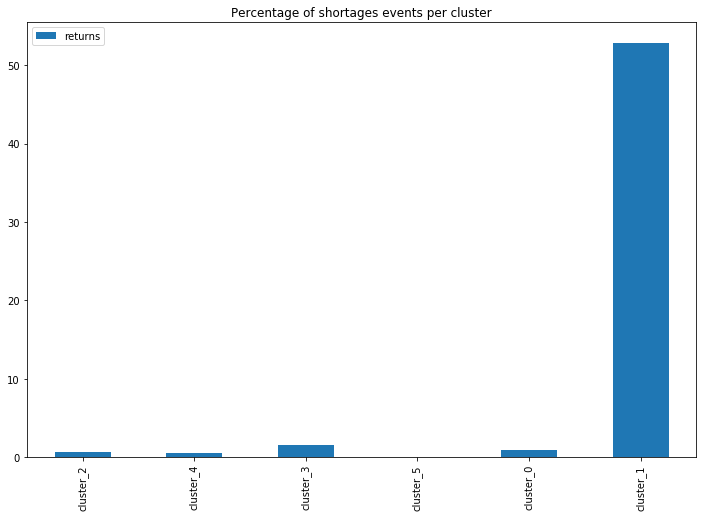

In [22]:
listy = {}
for a, i in df_dict.items():
    x = i[i['stock_open'] < 0]['stock_open'].count()/i['stock_open'].count()*100
    listy[a] = x
    
f, ax = plt.subplots(figsize=(12,8))
pd.DataFrame(listy, index=['returns']).T.plot(kind='bar', ax=ax)
plt.title('Percentage of shortages events per cluster')
plt.show()

Categorical variables per cluster

Some messy inferential stats:

In [25]:
analyze_som.test_continuous_feat(df_dict, run_cont)


 
 sales
                sum_sq         df              F  PR(>F)
cluster   5.792558e+08        5.0  593642.563469     0.0
Residual  4.852490e+08  2486505.0            NaN     NaN 

   Multiple Comparison of Means - Tukey HSD,FWER=0.05   
  group1    group2   meandiff   lower     upper   reject
--------------------------------------------------------
cluster_0 cluster_1  833.7682  832.358   835.1783  True 
cluster_0 cluster_2   -0.312   -0.3932   -0.2307   True 
cluster_0 cluster_3  -1.6831   -1.7644   -1.6018   True 
cluster_0 cluster_4   5.5898    5.4734    5.7062   True 
cluster_0 cluster_5   42.257   41.8189   42.6952   True 
cluster_1 cluster_2 -834.0801  -835.489 -832.6712  True 
cluster_1 cluster_3 -835.4513 -836.8602 -834.0424  True 
cluster_1 cluster_4 -828.1784 -829.5898  -826.767  True 
cluster_1 cluster_5 -791.5111 -792.9844 -790.0379  True 
cluster_2 cluster_3  -1.3711   -1.4278   -1.3145   True 
cluster_2 cluster_4   5.9017    5.801     6.0025   True 
cluster_2 cluster_5

Now moving to cumulative sales per cluster

In [23]:
som_sales_df = sales_df.merge(som_clus, on='sku_key')
som_sales_df.head()

sku_key  sales         0          1  sales_log  cluster
0   247497      9 -9.619623  -5.626536   0.954243        2
1   247498      3  6.406432   7.038271   0.477121        2
2   247501     59 -3.724324   1.657273   1.770852        0
3   247505    102  2.464536   1.509385   2.008600        3
4   247506      2 -4.125991 -10.280518   0.301030        2

cluster 2
15771


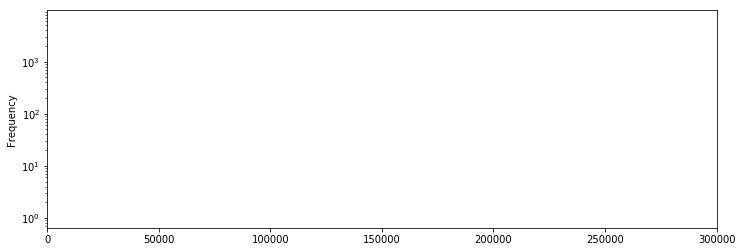

cluster 0
20392


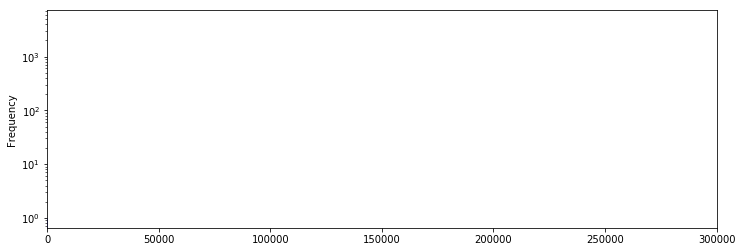

cluster 3
7776


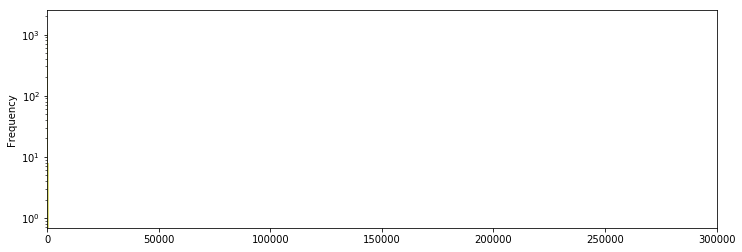

cluster 1
903


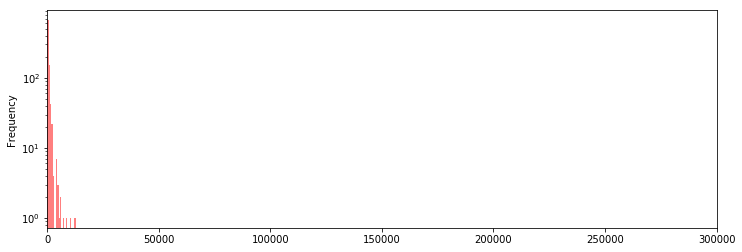

In [24]:
for i in som_sales_df['cluster'].unique():
    print('cluster {}'.format(i))
    print(len(som_sales_df[som_sales_df['cluster'] == i]['sales']))
    f, ax = plt.subplots(figsize=(12,4))
    som_sales_df[som_sales_df['cluster'] == i]['sales'].T.plot(kind='hist', color=colors[i], alpha=0.5, bins=20, ax=ax, logy=True)
    ax.set_xlim(-50, 300000)
    plt.show()

In [25]:
for a, i in enumerate(som_sales_df['cluster'].unique()):
    if a == 0:
        int_df = pd.DataFrame(som_sales_df[som_sales_df['cluster'] == i]['sales'])
        int_df.columns = [i]
    else:
        temp = pd.DataFrame(som_sales_df[som_sales_df['cluster'] == i]['sales'])
        temp.columns = [i]
        int_df = int_df.join(temp, how='outer')


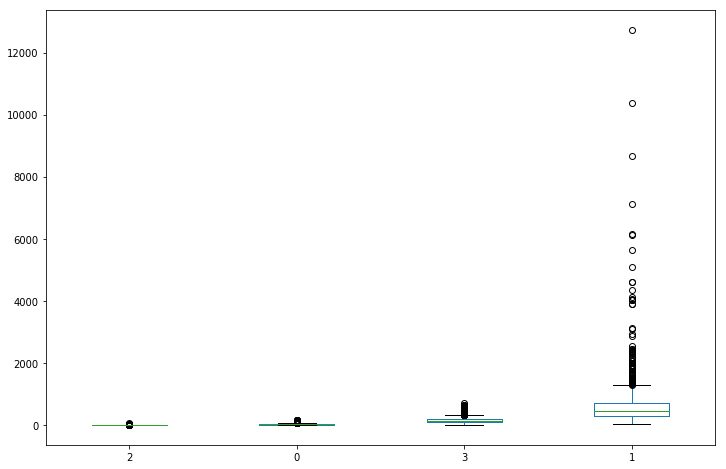

In [26]:
f, ax = plt.subplots(figsize=(12,8))
int_df.plot(kind='box', ax=ax)


In [46]:
int_df_unpiv = int_df.melt().dropna()
int_df_unpiv.columns = ['cluster', 'value']
int_df_unpiv.head()

cluster  value
0        3  122.0
1        3  153.0
2        3   35.0
4        3   89.0
5        3   82.0

In [47]:
mod = ols('value ~ cluster',
                data=int_df_unpiv).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)


                sum_sq      df          F    PR(>F)
cluster   5.531381e+08     1.0  14.572751  0.000137
Residual  1.736913e+11  4576.0        NaN       NaN


In [48]:
print(pairwise_tukeyhsd(int_df_unpiv['value'], int_df_unpiv['cluster']))

     Multiple Comparison of Means - Tukey HSD,FWER=0.05    
group1 group2   meandiff      lower        upper     reject
-----------------------------------------------------------
  0      1    222026.1941  219148.7985  224903.5897   True 
  0      2      535.8853     336.6955     735.0752    True 
  0      3      -419.763    -611.6467    -227.8794    True 
  0      4     3739.1435    3424.5831    4053.7039    True 
  0      5     22832.9024   21579.7177   24086.0871   True 
  1      2    -221490.3087 -224366.8638 -218613.7537  True 
  1      3    -222445.9571 -225322.0155 -219569.8987  True 
  1      4    -218287.0506 -221173.8898 -215400.2113  True 
  1      5    -199193.2917 -202324.6435 -196061.9398  True 
  2      3     -955.6484    -1134.4863   -776.8104    True 
  2      4     3203.2582    2896.4815    3510.0348    True 
  2      5     22297.0171   21045.7635   23548.2707   True 
  3      4     4158.9065    3856.8227    4460.9904    True 
  3      5     23252.6654   22002.5541  

In [28]:
two = 'Least sales'
zero = 'Less sales'
three = 'Moderate Sales'
one = 'Most sales'

In [29]:
map_dict = {2: two, 0:zero, 3:three, 1:one}

In [32]:
som_clus['description'] = som_clus['cluster'].map(map_dict)

In [33]:
som_clus.to_csv('footgear_clusters.csv')